In [2]:
import requests
import numpy as np
import re
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd
from pandas_market_calendars import get_calendar, MarketCalendar
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller



# Import Data

# Engineering Features

## Key ID via PostalCode

In [3]:
path = "C:/CodeTest1/Venv1/SalesFeb2023/"
file1 = "Query1.xlsx"
file2 = "Customer_PostalCodes.xlsx"
file3 = "Customer_Token_PostalCodes.xlsx"
df1 = pd.read_excel(path + file1)
df2 = pd.read_excel(path + file2)
df3 = pd.read_excel(path + file3)

In [14]:
df3.CustomerName.nunique(),df1.CustomerName.nunique()

(3547, 191)

In [16]:
# df3.join(df1,'CustomerName')
pd.merge(df1, df3, on='CustomerName', how='left').isna().sum()


SalesDate       0
CustomerName    0
C_TotalSales    0
token           0
PostalCode      0
dtype: int64

In [17]:
df = pd.merge(df1, df3, on='CustomerName', how='left')

In [19]:
df

,SalesDate,CustomerName,C_TotalSales,token,PostalCode
0,2022-07-06,Raaga Indian Kitchen and Bar,569.69,5ACECA1F-8DEC-40DE-8D58-DA1E8D831243,33647
1,2022-11-06,"Bawarchi Biryanis - Fort Collins, CO",4114.14,EAC9E169-C3C7-460B-8E01-863E7A70F9D7,80525
2,2023-02-09,"Aappakadai Indian Chettinad - Santa Clara, CA",2573.13,5D21088F-6603-4ECD-A4DA-237DE018C8FD,95051
3,2022-06-08,Cafe Delhi,4474.28,96963192-532C-4AD8-87AC-22A9DDF2E87C,15106
4,2022-11-19,"Bawarchi Biryanis - Mississauga, ON",11165.23,3D18974D-7054-4402-A55A-B00DC0B99AE7,L5R 0G2
...,...,...,...,...,...
32890,2022-11-03,"Taste of India - St Augustine, FL",3964.99,1B423DD3-13C4-4F40-BC41-1D8C838C2665,32092
32891,2022-12-31,"Minerva Indian Restaurant - Jacksonville, FL",509.49,991F8469-E3F3-444B-8E09-0452F1989DEB,32256
32892,2022-10-25,"Bawarchi Biryanis - Schaumburg, IL",448.00,B10E246B-051A-4299-8BA7-2456F38DD45A,60194
32893,2022-08-02,"Bawarchi Biryanis - West Des Moines, IA",10781.44,271EFD73-C828-4A4D-8C6D-D72E8E4EF0C4,50266


In [21]:
df.loc[df.CustomerName == 'Aappakadai Indian Chettinad - Santa Clara, CA'].token.iloc[0]

'5D21088F-6603-4ECD-A4DA-237DE018C8FD'

## Search for customer by substring or token

In [8]:
# define the search phrase
search_phrase = 'Aappakadai Indian Chettinad'

# create a regular expression pattern
pattern = re.compile(search_phrase, flags=re.IGNORECASE)

# create a boolean mask to filter the dataframe based on the pattern
mask = df3['CustomerName'].str.contains(pattern)

# apply the boolean mask to the dataframe to get the filtered rows
postal_df = df3[mask]


# print the filtered dataframe
postal_df.iloc[1]

CustomerName    Aappakadai Indian Chettinad - Santa Clara, CA
token                    5D21088F-6603-4ECD-A4DA-237DE018C8FD
PostalCode                                              95051
Name: 3545, dtype: object

## Adding day of week and holiday (yes/no)

In [533]:
# Add on columns for day of week and is or is not holiday
df_ts = df1.copy()

# Add a column for the day of the week
df_ts['day_of_week'] = df_ts['SalesDate'].dt.strftime('%A')

# Create a calendar object for the NYSE
nyse = get_calendar('NYSE')

# Get the holiday calendar for the NYSE
nyse_holidays = nyse.schedule(start_date=df_ts['SalesDate'].min(), end_date=df_ts['SalesDate'].max())

# Add a column for whether each date is a holiday
df_ts['is_holiday'] = df_ts['SalesDate'].isin(nyse_holidays.index)

df_ts.shape

(32621, 5)

## Filter DataFrame by customer

In [534]:
# define the search phrase
search_phrase = 'Aappakadai Indian Chettinad - Santa Clara, CA'

# create a regular expression pattern
pattern = re.compile(search_phrase, flags=re.IGNORECASE)

# create a boolean mask to filter the dataframe based on the pattern
mask = df_ts['CustomerName'].str.contains(pattern)

# apply the boolean mask to the dataframe to get the filtered rows
filtered_df = df_ts[mask]

# print the filtered dataframe
print(filtered_df)

       SalesDate                                   CustomerName  C_TotalSales  \
2     2023-02-09  Aappakadai Indian Chettinad - Santa Clara, CA       2573.13   
416   2023-01-06  Aappakadai Indian Chettinad - Santa Clara, CA       6531.73   
533   2022-10-29  Aappakadai Indian Chettinad - Santa Clara, CA       5540.77   
673   2022-12-03  Aappakadai Indian Chettinad - Santa Clara, CA       7461.19   
829   2022-10-16  Aappakadai Indian Chettinad - Santa Clara, CA       7939.08   
...          ...                                            ...           ...   
32056 2022-06-03  Aappakadai Indian Chettinad - Santa Clara, CA       8213.16   
32083 2023-02-16  Aappakadai Indian Chettinad - Santa Clara, CA       2027.89   
32133 2023-01-13  Aappakadai Indian Chettinad - Santa Clara, CA      10740.93   
32186 2023-01-16  Aappakadai Indian Chettinad - Santa Clara, CA       3750.53   
32272 2022-12-13  Aappakadai Indian Chettinad - Santa Clara, CA       2343.51   

      day_of_week  is_holid

## Adding weather data

### Find the nearest station given a PostalCode

In [535]:
# Directory for stations.txt file along with postal code
api_key = 'sLyRxkcsmqBlZUQtwoVxrIGLkTAbTosu'  # Replace with your NOAA API key
data_directory = "C:/CodeTest1/Venv1/WeatherData/ghcnddata/"
postal_code = postal_df.iloc[1].PostalCode                                              
postal_code

'95051'

In [536]:


def nearest_stations(postal_code,data_directory):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(f'{postal_code},USA')
    latitude, longitude = location.latitude, location.longitude
    # Find the nearest station IDs 
    columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN_FLAG", "HCN_CRN_FLAG", "WMO_ID"]
    widths = [11, 9, 10, 7, 3, 31, 4, 4, 6]
    df_stations = pd.read_fwf(os.path.join(data_directory, "ghcnd-stations.txt"), names=columns, header=None, widths=widths)
    df_stations["DISTANCE"] = ((df_stations["LATITUDE"] - latitude) ** 2 + (df_stations["LONGITUDE"] - longitude) ** 2) ** 0.5
    # Sort the DataFrame by distance and select the top 5 nearest stations
    nearest_stations = df_stations.nsmallest(5, "DISTANCE")
    nearest_stations = nearest_stations.ID.tolist()
    return nearest_stations

In [537]:
# def closest_stations(postal_code,api_key):

# api_key = 'sLyRxkcsmqBlZUQtwoVxrIGLkTAbTosu'  # Replace with your NOAA API key
# endpoint = f'https://www.ncei.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&locationid=ZIP:95051&limit=15'
# response = requests.get(endpoint, headers={'token': api_key})
# response
# response.raise_for_status()
# data = response.json()
# data
# # nearest_stations = [station["id"] for station in data["results"]]
# nearest_stations

In [538]:
# Top 5 nearest stations
# closest_stations = closest_stations(postal_code,api_key)

In [539]:
# Top 5 nearest stations
nearest_stations = nearest_stations(postal_code,data_directory)

In [540]:
nearest_stations

['US1CASC0003', 'US1CASC0042', 'US1CASC0032', 'USC00047912', 'USC00047821']

In [541]:
# startdate=filtered_df.SalesDate.min().strftime('%Y-%m-%d')
# enddate=filtered_df.SalesDate.max().strftime('%Y-%m-%d')
# startdate

### Precipitation

In [542]:
api_key = 'sLyRxkcsmqBlZUQtwoVxrIGLkTAbTosu'
startdate=filtered_df.SalesDate.min().strftime('%Y-%m-%d')
enddate=filtered_df.SalesDate.max().strftime('%Y-%m-%d')
def get_weather_data(station_id, api_key,startdate,enddate,type):
    endpoint = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:{station_id}&startdate={startdate}&enddate={enddate}&datatypeid={type}&limit=500'
    response = requests.get(endpoint, headers={'token': api_key})
    response.raise_for_status()
    data = response.json()
    return data

In [543]:
def is_complete_dataframe(df, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    return len(df) == len(date_range) and (df.index == date_range).all()

weather_data = {}
nearest_station_index = 0

while not weather_data and nearest_station_index < len(nearest_stations):
    station_id = nearest_stations[nearest_station_index]
    data = get_weather_data(station_id, api_key, startdate, enddate, 'PRCP')
    
    if 'results' in data:
        weather_data = data['results']
        dfPRCP = pd.DataFrame(weather_data)
        dfPRCP.set_index(pd.to_datetime(dfPRCP['date']), inplace=True)
        
        if not is_complete_dataframe(dfPRCP, startdate, enddate):
            weather_data = {}
    
    nearest_station_index += 1

if weather_data:
    print(dfPRCP)
else:
    print("No full dataset found for the top 5 nearest stations.")


                           date datatype            station attributes  value
date                                                                         
2022-06-01  2022-06-01T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      0
2022-06-02  2022-06-02T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      0
2022-06-03  2022-06-03T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      0
2022-06-04  2022-06-04T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      0
2022-06-05  2022-06-05T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      0
...                         ...      ...                ...        ...    ...
2023-02-25  2023-02-25T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      8
2023-02-26  2023-02-26T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700      0
2023-02-27  2023-02-27T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700     51
2023-02-28  2023-02-28T00:00:00     PRCP  GHCND:US1CASC0032   ,,N,0700    124
2023-03-01  2023-03-01T00:00:00     PRCP  GHCND:US1CASC0032   ,,

In [544]:
#Converts to degrees Celsius
dfPRCP['value'] = dfPRCP['value']/10

##### Prep PRCP DataFrame

In [545]:
dfPRCP_prep = dfPRCP[['date','value']].copy()
dfPRCP_prep.rename(columns={'date': 'SalesDate', 'value': 'PRCP'}, inplace=True)

dfPRCP_prep.isna().sum()

SalesDate    0
PRCP         0
dtype: int64

In [546]:
dfPRCP_prep.shape

(274, 2)

### Temperature

#### Min Temperature

In [547]:
def is_complete_dataframe(df, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    return len(df) == len(date_range) and (df.index == date_range).all()

weather_data = {}
nearest_station_index = 0

while not weather_data and nearest_station_index < len(nearest_stations):
    station_id = nearest_stations[nearest_station_index]
    data = get_weather_data(station_id, api_key, startdate, enddate, 'TMIN')
    
    if 'results' in data:
        weather_data = data['results']
        dfTMIN = pd.DataFrame(weather_data)
        dfTMIN.set_index(pd.to_datetime(dfTMIN['date']), inplace=True)
        
        if not is_complete_dataframe(dfTMIN, startdate, enddate):
            weather_data = {}
    
    nearest_station_index += 1

if weather_data:
    print(dfTMIN)
else:
    print("No full dataset found for the top 5 nearest stations.")


                           date datatype            station attributes  value
date                                                                         
2022-06-01  2022-06-01T00:00:00     TMIN  GHCND:USC00047821       ,,H,    117
2022-06-02  2022-06-02T00:00:00     TMIN  GHCND:USC00047821       ,,H,    133
2022-06-03  2022-06-03T00:00:00     TMIN  GHCND:USC00047821       ,,H,    139
2022-06-04  2022-06-04T00:00:00     TMIN  GHCND:USC00047821       ,,H,    150
2022-06-05  2022-06-05T00:00:00     TMIN  GHCND:USC00047821       ,,H,    167
...                         ...      ...                ...        ...    ...
2023-02-25  2023-02-25T00:00:00     TMIN  GHCND:USC00047821       ,,H,     33
2023-02-26  2023-02-26T00:00:00     TMIN  GHCND:USC00047821       ,,H,     67
2023-02-27  2023-02-27T00:00:00     TMIN  GHCND:USC00047821       ,,H,     33
2023-02-28  2023-02-28T00:00:00     TMIN  GHCND:USC00047821       ,,H,     50
2023-03-01  2023-03-01T00:00:00     TMIN  GHCND:USC00047821     

##### Prep TMIN DataFrame

In [548]:
#Converts to degrees Celsius
dfTMIN['value'] = dfTMIN['value']/10

In [549]:
dfTMIN_prep = dfTMIN[['date','value']].copy()
dfTMIN_prep.rename(columns={'date': 'SalesDate', 'value': 'TMIN'}, inplace=True)
dfTMIN_prep.isna().sum()

SalesDate    0
TMIN         0
dtype: int64

#### Max Temperature

In [550]:
def is_complete_dataframe(df, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    return len(df) == len(date_range) and (df.index == date_range).all()

weather_data = {}
nearest_station_index = 0

while not weather_data and nearest_station_index < len(nearest_stations):
    station_id = nearest_stations[nearest_station_index]
    data = get_weather_data(station_id, api_key, startdate, enddate, 'TMAX')
    
    if 'results' in data:
        weather_data = data['results']
        dfTMAX = pd.DataFrame(weather_data)
        dfTMAX.set_index(pd.to_datetime(dfTMAX['date']), inplace=True)
        
        if not is_complete_dataframe(dfTMAX, startdate, enddate):
            weather_data = {}
    
    nearest_station_index += 1

if weather_data:
    print(dfTMAX)
else:
    print("No full dataset found for the top 5 nearest stations.")

                           date datatype            station attributes  value
date                                                                         
2022-06-01  2022-06-01T00:00:00     TMAX  GHCND:USC00047821       ,,H,    294
2022-06-02  2022-06-02T00:00:00     TMAX  GHCND:USC00047821       ,,H,    250
2022-06-03  2022-06-03T00:00:00     TMAX  GHCND:USC00047821       ,,H,    239
2022-06-04  2022-06-04T00:00:00     TMAX  GHCND:USC00047821       ,,H,    244
2022-06-05  2022-06-05T00:00:00     TMAX  GHCND:USC00047821       ,,H,    272
...                         ...      ...                ...        ...    ...
2023-02-25  2023-02-25T00:00:00     TMAX  GHCND:USC00047821       ,,H,    122
2023-02-26  2023-02-26T00:00:00     TMAX  GHCND:USC00047821       ,,H,    111
2023-02-27  2023-02-27T00:00:00     TMAX  GHCND:USC00047821       ,,H,    100
2023-02-28  2023-02-28T00:00:00     TMAX  GHCND:USC00047821       ,,H,    117
2023-03-01  2023-03-01T00:00:00     TMAX  GHCND:USC00047821     

##### Prep TMAX DataFrame

In [551]:
#Converts to degrees Celsius
dfTMAX['value'] = dfTMAX['value']/10

In [552]:
dfTMAX_prep = dfTMAX[['date','value']].copy()
dfTMAX_prep.rename(columns={'date': 'SalesDate', 'value': 'TMAX'}, inplace=True)
dfTMAX_prep.isna().sum()

SalesDate    0
TMAX         0
dtype: int64

##### Prep TAVG DataFrame

In [553]:
dfTAVG_prep = dfTMAX_prep.copy()
dfTAVG_prep['TAVG'] = (dfTMAX_prep.TMAX + dfTMIN_prep.TMIN)/2
dfTAVG_prep.drop('TMAX',axis=1,inplace=True)
dfTAVG_prep.isna().sum()

SalesDate    0
TAVG         0
dtype: int64

# Create DataFrame Phase1

In [554]:
# Set time index
filtered_df.set_index('SalesDate', inplace=True)
dfPRCP_prep.set_index('SalesDate', inplace=True)
dfTMIN_prep.set_index('SalesDate', inplace=True)
dfTMAX_prep.set_index('SalesDate', inplace=True)
dfTAVG_prep.set_index('SalesDate', inplace=True)

# Convert the index to a DatetimeIndex
dfPRCP_prep.index = pd.to_datetime(dfPRCP_prep.index)
dfTMIN_prep.index = pd.to_datetime(dfTMIN_prep.index)
dfTMAX_prep.index = pd.to_datetime(dfTMAX_prep.index)
dfTAVG_prep.index = pd.to_datetime(dfTAVG_prep.index)

# Check the new index type
print(dfTAVG_prep.index)

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', name='SalesDate', length=274, freq=None)


In [555]:
# check for missing dates in each dataframe
# missing_dates_df1 = pd.date_range(start='2022-06-01', end='2023-03-01').difference(filtered_df.index)
# missing_dates_df2 = pd.date_range(start='2022-06-01', end='2023-03-01').difference(dfPRCP_prep.index)
# missing_dates_df3 = pd.date_range(start='2022-06-01', end='2023-03-01').difference(dfTMIN_prep.index)
# missing_dates_df4 = pd.date_range(start='2022-06-01', end='2023-03-01').difference(dfTMAX_prep.index)
# missing_dates_df5 = pd.date_range(start='2022-06-01', end='2023-03-01').difference(dfTAVG_prep.index)
# print("Missing dates in df1:")
# print(missing_dates_df1)
# print("\nMissing dates in df2:")
# print(missing_dates_df2)
# print("\nMissing dates in df3:")
# print(missing_dates_df3)
# print("\nMissing dates in df4:")
# print(missing_dates_df4)
# print("\nMissing dates in df5:")
# print(missing_dates_df5)


In [556]:
# filtered_df.set_index('SalesDate', inplace=True)
# filtered_df.set_index('SalesDate', inplace=True)
# dfPRCP_prep.set_index('SalesDate', inplace=True)
# dfTMIN_prep.set_index('SalesDate', inplace=True)
# dfTMAX_prep.set_index('SalesDate', inplace=True)
# dfTMAX_prep.index

merged_df = pd.concat([filtered_df, dfPRCP_prep,dfTMIN_prep, dfTMAX_prep, dfTAVG_prep], axis=1)

# Merge DataFrames on time index
# merged_df = filtered_df.merge(dfPRCP_prep, left_index=True, right_index=True, how='outer')
# merged_df = filtered_df.merge(dfTMIN_prep, left_index=True, right_index=True, how='outer')
# merged_df = merged_df.merge(dfTMAX_prep, left_index=True, right_index=True, how='outer')
# merged_df = merged_df.merge(dfTAVG_prep, left_index=True, right_index=True, how='outer')

print(merged_df)


                                             CustomerName  C_TotalSales  \
SalesDate                                                                 
2022-06-01  Aappakadai Indian Chettinad - Santa Clara, CA       3187.39   
2022-06-02  Aappakadai Indian Chettinad - Santa Clara, CA       2594.12   
2022-06-03  Aappakadai Indian Chettinad - Santa Clara, CA       8213.16   
2022-06-04  Aappakadai Indian Chettinad - Santa Clara, CA       6712.50   
2022-06-05  Aappakadai Indian Chettinad - Santa Clara, CA       6132.96   
...                                                   ...           ...   
2023-02-25  Aappakadai Indian Chettinad - Santa Clara, CA       5957.86   
2023-02-26  Aappakadai Indian Chettinad - Santa Clara, CA       5665.28   
2023-02-27  Aappakadai Indian Chettinad - Santa Clara, CA       2344.98   
2023-02-28  Aappakadai Indian Chettinad - Santa Clara, CA       3340.90   
2023-03-01  Aappakadai Indian Chettinad - Santa Clara, CA       2779.86   

           day_of_week  

In [557]:
merged_df.isna().sum()

CustomerName    0
C_TotalSales    0
day_of_week     0
is_holiday      0
PRCP            0
TMIN            0
TMAX            0
TAVG            0
dtype: int64

#### Fill Nans with rolling average

In [558]:
# # Set the window size for the rolling average
# window_size = 3

# # Compute the rolling average of the last 3 days and next 4 days
# merged_df['rolling_avg'] = merged_df['DailyAvgPRCP'].rolling(window=window_size, min_periods=1, center=True).mean()

# # Forward-fill missing values at the beginning of the time series
# merged_df['rolling_avg'] = merged_df['rolling_avg'].fillna(method='ffill')

# # Backward-fill missing values at the end of the time series
# merged_df['rolling_avg'] = merged_df['rolling_avg'].fillna(method='bfill')

# # Filling in the Average Percip Column
# merged_df['DailyAvgPRCP'].fillna(merged_df['rolling_avg'], inplace=True)

In [559]:
merged_df.isna().sum()

CustomerName    0
C_TotalSales    0
day_of_week     0
is_holiday      0
PRCP            0
TMIN            0
TMAX            0
TAVG            0
dtype: int64

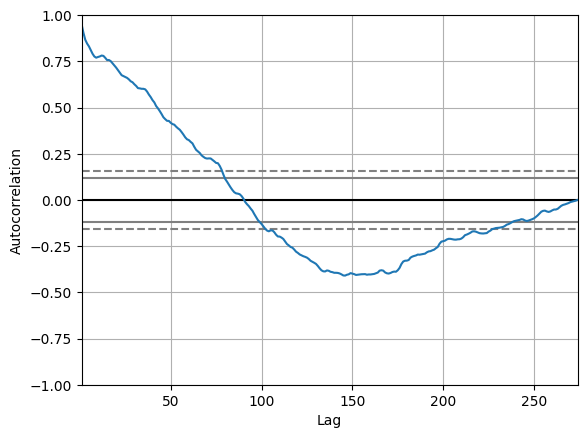

In [560]:
# autocorrelation_plot(merged_df.C_TotalSales)
autocorrelation_plot(merged_df.TAVG)

plt.show()

## Create Lag Features

### Use ARIMA Model to determine Lags

                               SARIMAX Results                                
Dep. Variable:           C_TotalSales   No. Observations:                  274
Model:                 ARIMA(9, 1, 0)   Log Likelihood               -2603.587
Date:                Fri, 17 Mar 2023   AIC                           5249.174
Time:                        14:21:48   BIC                           5324.973
Sample:                    06-01-2022   HQIC                          5279.601
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRCP         -17.6642     48.874     -0.361      0.718    -113.456      78.127
TAVG         193.5672    142.455      1.359      0.174     -85.640     472.774
Friday      4243.0777   3491.782      1.215      0.2

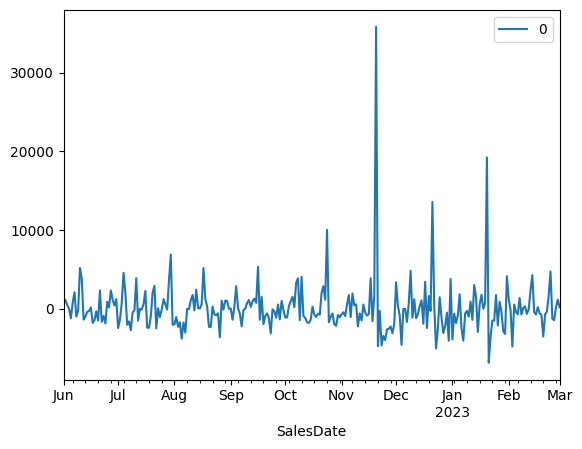

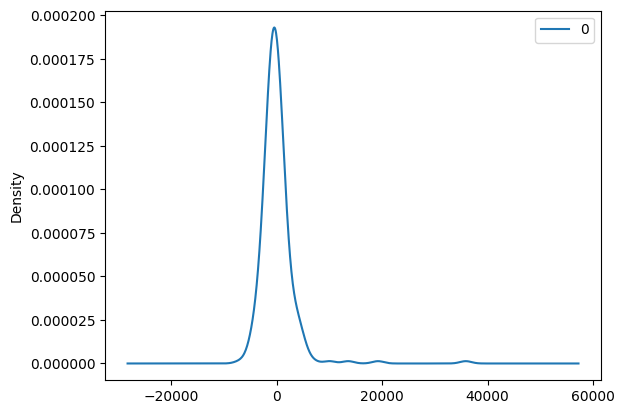

                  0
count    274.000000
mean      62.034563
std     3349.076498
min    -6861.913318
25%    -1411.807541
50%     -290.996509
75%      959.007003
max    35854.439107


In [561]:

# fit an ARIMA model with exogeneous variables and plot residual errors
#Create Exogeneous vars
exog_df = merged_df[['day_of_week','is_holiday','PRCP','TAVG']]
# get the dummies and store it in a variable
dummies1 = pd.get_dummies(exog_df.day_of_week)
dummies2 = pd.get_dummies(exog_df.is_holiday)
# Concatenate the dummies to original dataframe
exog_df = pd.concat([exog_df, dummies1, dummies2], axis='columns')
# drop the values
exog_df.drop(['day_of_week','is_holiday'], axis='columns',inplace=True)
# Check that variables have same shape for model

# load dataset
df = merged_df.C_TotalSales
# fit model
model = ARIMA(df, exog =exog_df, order=(9,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Check for optimal Lag

In [563]:
# BIC Criterion to compute optimal lag 

# Restric to Daily Total Sales Column
# load dataset
df = merged_df.C_TotalSales
# Define a range of lag lengths to consider
lags = range(1, 10)
# Fit a model for each lag length and compute the BIC
bics = []
for lag in lags:
    # Create the lagged variables
    df_lagged = pd.concat([df.shift(i) for i in range(lag+1)], axis=1)
    df_lagged.columns = ['y'] + ['L' + str(i) for i in range(1, lag+1)]    
    df_lagged = df_lagged.fillna('bfill')
    # Fit an ARIMA model with a constant term
    model = sm.tsa.ARIMA(df_lagged['y'], order=(lag, 0, 0), exog=exog_df, trend='c',freq='D')
    results = model.fit()

    # Compute the BIC
    bics.append(results.bic)

# Choose the lag length that minimizes the BIC
optimal_lag = lags[bics.index(min(bics))]
optimal_lag

1

In [564]:
# AIC Method
df = merged_df.C_TotalSales

# Check if the data is stationary
result = adfuller(df)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If the data is non-stationary, consider differencing it
if result[1] > 0.05:
    df = df.diff().dropna()

# Determine the optimal lag using the AIC
def find_optimal_lag(df, max_lag):
    best_aic = np.inf
    best_lag = None

    for lag in range(1, max_lag + 1):
        model = ARIMA(df, order=(lag, 0, 0),exog=exog_df,trend='c',freq='D')
        result = model.fit()
        aic = result.aic
        
        if aic < best_aic:
            best_aic = aic
            best_lag = lag
    
    return best_lag, best_aic

max_lag = 50  # You can set this to an appropriate value based on your data
best_lag, best_aic = find_optimal_lag(df, max_lag)

print(f"The optimal lag is {best_lag} with an AIC of {best_aic}")


ADF Statistic: -6.006194787958071
p-value: 1.6133739433158368e-07
The optimal lag is 1 with an AIC of 5225.476499871415


In [571]:
def create_lagged_features(df, optimal_lag):
    for i in range(1, optimal_lag + 1):
        df[f'lag_{i}'] = df.C_TotalSales.shift(i)
    return df


In [629]:
df = create_lagged_features(merged_df.copy(), optimal_lag)
df.fillna(method='bfill',inplace=True)
df.shape


(274, 9)

In [630]:
dummies1 = pd.get_dummies(df.day_of_week)
dummies2 = pd.get_dummies(df.is_holiday)
# Concatenate the dummies to original dataframe
df = pd.concat([df, dummies1, dummies2], axis='columns')
# drop the values
df.drop(['day_of_week','is_holiday','CustomerName'], axis='columns',inplace=True)
df.columns = df.columns.astype('str')
# Check that variables have same shape for model
df.isna().sum()

C_TotalSales    0
PRCP            0
TMIN            0
TMAX            0
TAVG            0
lag_1           0
Friday          0
Monday          0
Saturday        0
Sunday          0
Thursday        0
Tuesday         0
Wednesday       0
False           0
True            0
dtype: int64

### Use ML

In [631]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [632]:
X_train = train.drop(['C_TotalSales'], axis=1)
y_train = train['C_TotalSales']
X_test = test.drop(['C_TotalSales'], axis=1)
y_test = test['C_TotalSales']


In [633]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [635]:

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Keep the top k important features
k = len(X_train.columns)
top_k_features = sorted_idx[:k]
X_train_selected = X_train.iloc[:, top_k_features]
X_test_selected = X_test.iloc[:, top_k_features]


In [626]:
len(X_train.columns)

14

In [653]:
#(feature_importances >= 0.09)
importance = dict(zip(X_train.columns,feature_importances))
filtered_dict = {key: value for key, value in importance.items() if value > 0.09}

In [654]:
model_captured = sum(list(filtered_dict.values()))

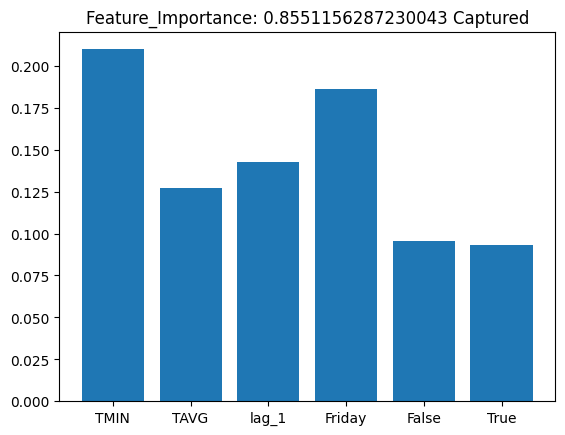

In [655]:

# Create a bar plot
plt.bar(filtered_dict.keys(), filtered_dict.values())
plt.title('Feature_Importance: ' + str(model_captured) + ' Captured')
# Show the plot
plt.show()


In [670]:
X_train_selected = X_train
X_test_selected = X_test
X_test_selected

,PRCP,TMIN,TMAX,TAVG,lag_1,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,False,True
SalesDate,,,,,,,,,,,,,,
2023-01-06,9.4,8.9,16.1,12.50,3891.94,1,0,0,0,0,0,0,0,1
2023-01-07,0.3,10.6,17.2,13.90,6531.73,0,0,1,0,0,0,0,1,0
2023-01-08,15.0,10.0,16.7,13.35,4538.44,0,0,0,1,0,0,0,1,0
2023-01-09,30.0,10.0,15.6,12.80,6189.15,0,1,0,0,0,0,0,0,1
2023-01-10,11.9,9.4,14.4,11.90,1727.22,0,0,0,0,0,1,0,0,1
2023-01-11,8.4,10.6,14.4,12.50,1458.30,0,0,0,0,0,0,1,0,1
2023-01-12,1.5,12.2,20.0,16.10,3574.62,0,0,0,0,1,0,0,0,1
2023-01-13,0.3,12.2,15.6,13.90,1576.47,1,0,0,0,0,0,0,0,1
2023-01-14,30.2,9.4,15.6,12.50,10740.93,0,0,1,0,0,0,0,1,0


In [671]:
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

In [672]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')


MAE: 3954.110941818183, MSE: 37534200.596073225, RMSE: 6126.5161875304975


In [ ]:
#w/TAVG
'MAE: 4003.7584145454557, MSE: 38735439.06425123, RMSE: 6223.780126599206'
#w/outTAVG
'MAE: 4281.520034545456, MSE: 43862400.77605009, RMSE: 6622.869527331041'
#w/Everything
'MAE: 3954.110941818183, MSE: 37534200.596073225, RMSE: 6126.5161875304975'

# Pickel DataFrame(s)

In [ ]:
with open('dataframes_and_importances.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Access the loaded dataframes and the list of feature importances
loaded_df1 = loaded_data['dataframe1']
loaded_df2 = loaded_data['dataframe2']
loaded_feature_importances = loaded_data['feature_importances']
